<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bayesian-R2" data-toc-modified-id="Bayesian-R2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bayesian R2</a></span></li><li><span><a href="#Effective-sample-size" data-toc-modified-id="Effective-sample-size-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Effective sample size</a></span></li><li><span><a href="#Log-likelihood" data-toc-modified-id="Log-likelihood-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Log likelihood</a></span></li><li><span><a href="#Rhat" data-toc-modified-id="Rhat-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Rhat</a></span></li></ul></div>

In [8]:
import os
import glob
import biom
import numpy as np
import pandas as pd
import xarray as xr
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dask
from dask.distributed import Client
from arviz.utils import Dask
benchmarking_dir = '../sfari/data/sra/Benchmarking'

dask.config.set(temporary_directory='/scratch')
%matplotlib inline

In [9]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})
client = Client(threads_per_worker=2, n_workers=20, memory_limit="20GB")

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45649 instead
  warnings.warn(


In [10]:
mean_files = glob.glob(f'{benchmarking_dir}/mean_differentials*-v2.nc')
match_files = glob.glob(f'{benchmarking_dir}/differentials*-v5.nc')
biom_files = glob.glob(f'{benchmarking_dir}/matched*')
mean_files.sort()
match_files.sort()
biom_files.sort()

In [11]:
mean_files

['../sfari/data/sra/Benchmarking/mean_differentials_0-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_1-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_2-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_3-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_4-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_5-v2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_6-v2.nc']

In [12]:
match_files

['../sfari/data/sra/Benchmarking/differentials_0-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_1-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_2-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_3-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_4-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_5-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_6-v5.nc']

In [13]:
biom_files

['../sfari/data/sra/Benchmarking/matched_0.biom',
 '../sfari/data/sra/Benchmarking/matched_1.biom',
 '../sfari/data/sra/Benchmarking/matched_2.biom',
 '../sfari/data/sra/Benchmarking/matched_3.biom',
 '../sfari/data/sra/Benchmarking/matched_4.biom',
 '../sfari/data/sra/Benchmarking/matched_5.biom',
 '../sfari/data/sra/Benchmarking/matched_6.biom']

In [14]:
mean_kwargs={'posterior':{'chunks': {'feature': 100}}}
match_kwargs={'posterior':{'chunks': {'features': 100}}}

mean_diffs = [az.from_netcdf(x, group_kwargs=mean_kwargs) for x in mean_files]
match_diffs = [az.from_netcdf(x, group_kwargs=match_kwargs) for x in match_files]
bioms = [biom.load_table(x) for x in biom_files]

In [15]:
bioms[1]

724 x 182 <class 'biom.table.Table'> with 17693 nonzero entries (13% dense)

In [16]:
mean_diffs[0].posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 100, feature: 537, group: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * group    (group) object 'Control' '1'
  * feature  (feature) object 'AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...
Data variables:
    beta     (feature, chain, draw) float64 dask.array<chunksize=(100, 4, 100), meta=np.ndarray>
    alpha    (feature, chain, draw, group) float64 dask.array<chunksize=(100, 4, 100, 2), meta=np.ndarray>
Attributes:
    created_at:                 2022-02-06T00:06:59.740767
    arviz_version:              0.11.4
    inference_library:          cmdstanpy
    inference_library_version:  0.9.68

# Bayesian R2

In [17]:
def r2_match_func(x):
    m, b = x
    y_obs = xr.DataArray(b.matrix_data.todense())
    y_obs = y_obs.stack(feature=('dim_0', 'dim_1'))
    y_pred = m.posterior_predictive.stack(xsample=("chain", "draw"))
    y_pred = y_pred.stack(feature=('features', 'samples'))['y_predict']
    y_pred = y_pred.fillna(0)  # get rid of nans
    return az.r2_score(y_obs.values, y_pred.values)

def r2_mean_func(x):
    m, b = x
    y_obs = xr.DataArray(b.matrix_data.todense())
    y_obs = y_obs.stack(feature=('dim_0', 'dim_1'))
    y_pred = m.posterior_predictive.stack(xsample=("chain", "draw"))
    y_pred = y_pred.stack(xfeature=('feature', 'tbl_sample'))['y_predict']
    y_pred = y_pred.fillna(0)  # get rid of nans
    return az.r2_score(y_obs.values, y_pred.values)

In [18]:
mean_diffs[0]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [19]:
match_diffs[0]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [20]:
bioms

[537 x 172 <class 'biom.table.Table'> with 17481 nonzero entries (18% dense),
 724 x 182 <class 'biom.table.Table'> with 17693 nonzero entries (13% dense),
 818 x 216 <class 'biom.table.Table'> with 22403 nonzero entries (12% dense),
 923 x 260 <class 'biom.table.Table'> with 27648 nonzero entries (11% dense),
 1058 x 338 <class 'biom.table.Table'> with 36404 nonzero entries (10% dense),
 1525 x 406 <class 'biom.table.Table'> with 56247 nonzero entries (9% dense),
 2105 x 684 <class 'biom.table.Table'> with 149409 nonzero entries (10% dense)]

In [21]:
mean_r2 = dask.compute(*[r2_mean_func(x) for x in zip(mean_diffs, bioms)])
match_r2 = dask.compute(*[r2_match_func(x) for x in zip(match_diffs, bioms)])

In [22]:
mean_r2 = pd.concat(mean_r2, axis=1).T
match_r2 = pd.concat(match_r2, axis=1).T

[172, 182, 216, 260, 338, 406, 684]

Text(0.5, 0, 'Number of aggregated datasets')

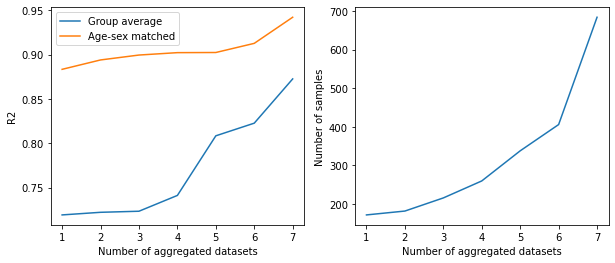

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 + np.arange(len(mean_r2)),
           mean_r2.r2, label='Group average')
ax[0].plot(1 + np.arange(len(match_r2)), 
           match_r2.r2, label='Age-sex matched')
ax[0].set_ylabel('R2')
ax[0].set_xlabel('Number of aggregated datasets')
ax[0].legend()

ns = [b.shape[1] for b in bioms]
ax[1].plot(1 + np.arange(len(ns)), ns)
ax[1].set_ylabel('Number of samples')
ax[1].set_xlabel('Number of aggregated datasets')

In [24]:
mean_r2.to_csv('../results/benchmarking/mean_r2.csv')
match_r2.to_csv('../results/benchmarking/match_r2.csv')

# Effective sample size

In [ ]:
mean_ess = dask.compute(*[az.ess(x) for x in mean_diffs])
match_ess = dask.compute(*[az.ess(x) for x in match_diffs])

In [ ]:
mean_mess = dask.compute(*[x['beta'].mean() for x in mean_ess])
match_mess = dask.compute(*[x['diff'].mean() for x in match_ess])

In [ ]:
mean_sess = dask.compute(*[x['beta'].std() for x in mean_ess])
match_sess = dask.compute(*[x['diff'].std() for x in match_ess])

In [ ]:
mean_mess = np.hstack(mean_mess)
match_mess = np.hstack(match_mess)

mean_sess = np.hstack(mean_sess)
match_sess = np.hstack(match_sess)

In [ ]:
plt.plot(mean_mess, label='Group average')
plt.plot(match_mess, label='Age-sex matched')
plt.legend()
plt.ylabel('Effective sample size')
plt.xlabel('Datasets')

In [ ]:
pd.DataFrame({'mean_ess': mean_mess, 'std_ess': mean_sess}).to_csv('../results/benchmarking/mean_ess.csv')
pd.DataFrame({'match_ess': match_mess, 'std_ess': match_sess}).to_csv('../results/benchmarking/match_ess.csv')

# Log likelihood

In [ ]:
mean_ll = dask.compute(*[x.log_likelihood.log_lhood.mean() for x in mean_diffs])
match_ll = dask.compute(*[x.log_likelihood.log_lhood.mean() for x in match_diffs])

In [ ]:
mean_ll = np.hstack(mean_ll)
match_ll = np.hstack(match_ll)

In [ ]:
plt.plot(mean_ll, label='Group average')
plt.plot(match_ll, label='Age-sex matched')
plt.legend()
plt.ylabel('Log Likelihood')
plt.xlabel('Datasets')

In [ ]:
pd.DataFrame({'mean_ll': mean_ll}).to_csv('../results/benchmarking/mean_ll.csv')
pd.DataFrame({'match_ll': match_ll}).to_csv('../results/benchmarking/match_ll.csv')

# Rhat

In [ ]:
mean_rhat = dask.compute(*[az.rhat(x) for x in mean_diffs])
match_rhat = dask.compute(*[az.rhat(x) for x in match_diffs])

mean_mrhat = dask.compute(*[x['beta'].mean() for x in mean_rhat])
match_mrhat = dask.compute(*[x['diff'].mean() for x in match_rhat])

mean_srhat = dask.compute(*[x['beta'].std() for x in mean_rhat])
match_srhat = dask.compute(*[x['diff'].std() for x in match_rhat])

mean_mrhat = np.hstack(mean_mrhat)
match_mrhat = np.hstack(match_mrhat)

mean_srhat = np.hstack(mean_srhat)
match_srhat = np.hstack(match_srhat)

In [ ]:
plt.plot(mean_mrhat, label='Group average')
plt.plot(match_mrhat, label='Age-sex matched')
plt.legend()
plt.ylabel('Rhat')
plt.xlabel('Datasets')

In [ ]:
pd.DataFrame({'mean_rhat': mean_mrhat, 'std_rhat': mean_srhat}).to_csv('../results/benchmarking/mean_rhat.csv')
pd.DataFrame({'match_rhat': match_mrhat, 'std_rhat': match_srhat}).to_csv('../results/benchmarking/match_rhat.csv')

In [ ]:
# LOO

In [ ]:
mean_loo = dask.compute(*[az.loo(x) for x in mean_diffs])
match_loo = dask.compute(*[az.loo(x) for x in match_diffs])

In [ ]:
print(mean_loo)

In [ ]:
print(match_loo)

In [ ]:
mean_loo_df = pd.DataFrame({'mean' : [x.values[0] for x in mean_loo],
                            'std': [x.values[1] for x in mean_loo]})
match_loo_df = pd.DataFrame({'mean' : [x.values[0] for x in match_loo],
                             'std': [x.values[1] for x in match_loo]})

In [ ]:
x = np.arange(len(mean_loo_df))
plt.errorbar(x, y=-mean_loo_df['mean'], yerr=mean_loo_df['std'], label='Group average')
plt.errorbar(x, y=-match_loo_df['mean'], yerr=match_loo_df['std'], label='Age-sex matched')
plt.ylabel('Expected log pointwise predictive density')
plt.xlabel('Datasets')
plt.legend()
plt.yscale('log')

In [ ]:
mean_loo_df.to_csv('../results/benchmarking/mean_loo.csv')
match_loo_df.to_csv('../results/benchmarking/match_loo.csv')

In [ ]:
client.close()